# Space Ship Titanic Kaggle Competition


1. imports
2. modules
3. load data
4. explore data
5. preprocess data
6. train model
7. evaluate model
8. write submission.csv

## Imports

In [1]:
# Standard Libraries
import numpy as np
import pandas as pd
from itertools import product

# Scikit-Learn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

# TensorFlow and Keras
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

# Plotting
import matplotlib.pyplot as plt

# Typing
from typing import Tuple, Dict
from numpy import ndarray
from pandas import DataFrame


2023-09-14 16:46:55.237494: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Custom Modules

### Handle Missing Names

In [2]:
def handle_missing_names(df: DataFrame) -> DataFrame:
    df["Name"] = df["Name"].fillna("unknown")
    return df


### Split Data on Char

In [3]:
def split_data_on_char(df: DataFrame, col: str, split_on_char: str) -> DataFrame:
    """
    Splits a DataFrame column into multiple columns based on a character.
    Leaves NaN values unchanged.

    Parameters:
        df (DataFrame): Input DataFrame
        col (str): Column name to split
        split_on_char (str): Character to split on

    Returns:
        DataFrame: DataFrame with new columns
    """
    # Split the column
    split_cols = df[col].str.split(split_on_char, expand=True)
    split_cols.columns = [f"{col}_{i+1}" for i in range(split_cols.shape[1])]

    # Drop the original column and concatenate the new columns
    df = pd.concat([df.drop(columns=[col]), split_cols], axis=1)

    return df


### Set Transported to binary

In [4]:
def set_transported_to_binary(df: DataFrame) -> DataFrame:
    if "Transported" in df.columns:
        df["Transported"] = df["Transported"].apply(lambda x: 1 if x == "True" else 0)
    return df


### Downcast Data Types

In [5]:
def downcast_columns(df: DataFrame, inplace: bool = False) -> DataFrame:
    """
    Downcasts columns in a DataFrame to reduce memory usage.

    Parameters:
        df (DataFrame): The input DataFrame.
        inplace (bool): Whether to modify the original DataFrame or return a new one.

    Returns:
        DataFrame: A DataFrame with downcasted columns.
    """
    if not inplace:
        df = df.copy()

    for dtype in ["int", "float"]:
        selected_columns = df.select_dtypes(include=[dtype]).columns
        for col in selected_columns:
            df[col] = pd.to_numeric(df[col], downcast=dtype)

    # Uncomment below to optionally downcast object types to category
    # for col in df.select_dtypes(include=['object']).columns:
    #     if len(df[col].unique()) / len(df[col]) < 0.5:
    #         df[col] = df[col].astype('category')

    return df


### Label Encode

In [6]:
def label_encode(df: DataFrame) -> Tuple[DataFrame, Dict[str, LabelEncoder]]:
    label_encoders = {}
    le = LabelEncoder()
    categorical_cols = df.select_dtypes(include=["object"]).columns
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le
    return df, label_encoders


### Separate Data

In [7]:
def separate_data(df: DataFrame) -> (DataFrame, DataFrame):
    df_no_missing = df.dropna()
    df_with_missing = df.loc[df.isna().any(axis=1)]
    return df_no_missing, df_with_missing


### Scale Features

In [8]:
def scale_features(
    df: DataFrame, target_col: str = None
) -> (DataFrame, StandardScaler):
    """
    Scales the features of a DataFrame.

    Parameters:
        df (DataFrame): The DataFrame to scale.
        target_col (str): The target column to exclude from scaling.

    Returns:
        DataFrame: The scaled DataFrame.
        StandardScaler: The scaler used for scaling.
    """
    scaler = StandardScaler()

    # Separate target if it exists
    if target_col and target_col in df.columns:
        target = df[target_col]
        features = df.drop(columns=[target_col])
    else:
        features = df

    # Scale features
    features_scaled = scaler.fit_transform(features)

    # Combine features and target back into a single DataFrame
    if target_col and target_col in df.columns:
        df_scaled = DataFrame(features_scaled, columns=features.columns, index=df.index)
        df_scaled[target_col] = target
    else:
        df_scaled = DataFrame(features_scaled, columns=features.columns, index=df.index)

    return df_scaled, scaler


### Train Autoencoder

In [9]:
def train_autoencoder(df_no_missing_scaled: DataFrame) -> Model:
    input_layer = Input(shape=(df_no_missing_scaled.shape[1],))
    encoder = Dense(128, activation="relu")(input_layer)
    encoder = Dense(64, activation="relu")(encoder)
    latent_space = Dense(32, activation="relu")(encoder)
    decoder = Dense(64, activation="relu")(latent_space)
    decoder = Dense(128, activation="relu")(decoder)
    output_layer = Dense(df_no_missing_scaled.shape[1], activation="linear")(decoder)
    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer="adam", loss="mean_squared_error")
    autoencoder.fit(
        df_no_missing_scaled, df_no_missing_scaled, epochs=50, batch_size=128, verbose=0
    )
    return autoencoder


### Impute Missing Values

In [10]:
def impute_missing_values(
    df_with_missing: DataFrame, autoencoder: Model, scaler: StandardScaler
) -> DataFrame:
    # Scale the feature set with missing values
    df_with_missing_scaled = scaler.transform(df_with_missing.fillna(0))

    # Use the autoencoder to predict the missing values
    imputed_values_scaled = autoencoder.predict(df_with_missing_scaled)

    # Inverse transform to get the original feature values
    imputed_values = scaler.inverse_transform(imputed_values_scaled)

    # Replace the missing values in the original DataFrame
    df_imputed = df_with_missing.copy()
    is_null = df_with_missing.isna()
    for i in range(df_with_missing.shape[0]):
        for j in range(df_with_missing.shape[1]):
            if is_null.iloc[i, j]:
                df_imputed.iloc[i, j] = imputed_values[i, j]

    return df_imputed


### PreProcess

In [11]:
from typing import Tuple


def preprocess(
    df: DataFrame, target_col: str = "Transported"
) -> Tuple[DataFrame, Dict[str, LabelEncoder]]:
    # Handle missing names
    df = handle_missing_names(df)

    # Split cabin column
    df = split_data_on_char(df, "Cabin", "/")

    # Separate out the target column
    if target_col in df.columns:
        target = df[target_col]
        features = df.drop(columns=[target_col])
    else:
        features = df

    # Exclude 'PassengerId' from the label encoding process
    if "PassengerId" in features.columns:
        passenger_ids = features["PassengerId"]
        features = features.drop(columns=["PassengerId"])
    else:
        passenger_ids = None

    # Label encode categorical columns and capture the label encoders
    features, label_encoders = label_encode(features)

    # If 'PassengerId' was excluded, add it back
    if passenger_ids is not None:
        features["PassengerId"] = passenger_ids

    # Separate rows with and without missing values
    features_no_missing, features_with_missing = separate_data(features)

    # Scale features
    features_no_missing_scaled, scaler = scale_features(features_no_missing)

    # Train autoencoder
    autoencoder = train_autoencoder(features_no_missing_scaled)

    # Impute missing values
    features_imputed = impute_missing_values(features_with_missing, autoencoder, scaler)

    # Combine imputed and non-missing rows
    complete_features = pd.concat([features_no_missing, features_imputed])

    # If the target exists, add it back
    if target_col in df.columns:
        complete_features[target_col] = target

    return complete_features, label_encoders


### Plot Training History

In [12]:
def plot_training_history_with_metrics(history, y_true, y_pred_proba):
    """
    Plots the training and validation loss, accuracy, and provides interpretations notes.
    Also calculates F1 Score and ROC AUC Score.

    Parameters:
        history (History): History object returned from model training.
        y_true (array-like): True labels for the validation set.
        y_pred_proba (array-like): Predicted probabilities for the positive class.

    """

    # Extract training and validation loss
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    # Extract training and validation accuracy if it exists
    accuracy = history.history.get("accuracy")
    val_accuracy = history.history.get("val_accuracy")

    # Create figure and axis
    fig, ax1 = plt.subplots()

    # Plot loss
    color = "tab:red"
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss", color=color)
    ax1.plot(loss, label="Train Loss", color=color)
    ax1.tick_params(axis="y", labelcolor=color)

    # Create another y-axis for the accuracies
    ax2 = ax1.twinx()

    color = "tab:blue"
    ax2.set_ylabel("Accuracy", color=color)

    # Plot accuracy if it exists
    if accuracy and val_accuracy:
        ax2.plot(accuracy, label="Train Acc", color=color)
        ax2.tick_params(axis="y", labelcolor=color)

    # Plot validation data if it exists
    if val_loss:
        ax1.plot(val_loss, label="Val Loss", color="tab:orange")

    if val_accuracy:
        ax2.plot(val_accuracy, label="Val Acc", color="tab:cyan")

    # Add legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines = lines1 + lines2
    labels = labels1 + labels2
    ax1.legend(lines, labels, loc=0)

    plt.show()

    # Additional Metrics
    y_pred = np.round(y_pred_proba)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    print(f"\nAdditional Metrics:")
    print(f"F1 Score: {f1}")
    print(f"ROC AUC Score: {roc_auc}")
    print()

    # Interpretation
    print("Interpreting the Graph:")
    print(
        "- F1 Score: 2 * (precision * recall) / (precision + recall).  The F1 Score is the harmonic mean of precision and recall. Precision measures how many of the items identified as positive are actually positive, while recall measures how many of the actual positive items are identified correctly."
    )
    print(
        "- ROC AUC Score: The Area Under the Receiver Operating Characteristic Curve (ROC AUC) is a measure of how well a model can distinguish between classes. An ROC AUC of 0.5 means the model is randomly guessing, while an ROC AUC of 1.0 means the model is perfectly distinguishing between positive and negative classes."
    )
    print("- A lower 'Loss' means the model is performing better.")
    print(
        "- 'Train Loss' and 'Val Loss' should follow a similar trend. If 'Val Loss' starts increasing while 'Train Loss' continues decreasing, it's likely the model is overfitting."
    )
    print(
        "- Higher 'Accuracy' is generally better, but be cautious if accuracy is very high as it might be a sign of overfitting or a too-simple model."
    )
    print(
        "- 'Train Acc' and 'Val Acc' should also follow similar trends. If 'Val Acc' plateaus or starts decreasing, consider stopping the training or modifying the model."
    )


### Create Submission Dataframe

In [13]:
def create_submission_dataframe(
    y_test_pred: ndarray, passenger_ids: ndarray, threshold: float = 0.5
) -> DataFrame:
    """
    Create a submission DataFrame.

    Parameters:
        y_test_pred (np.ndarray): Model predictions.
        passenger_ids (np.ndarray): IDs corresponding to the test set.
        threshold (float): Threshold for classifying as 1.

    Returns:
        DataFrame: Submission DataFrame.
    """
    # Convert probabilities to binary outputs
    y_test_pred_binary = (y_test_pred > threshold).astype(int).flatten()

    # Create a DataFrame for submission
    submission_df = DataFrame(
        {"PassengerId": passenger_ids, "Transported": y_test_pred_binary}
    )

    return submission_df


## Load Test and training Data

In [14]:
try:
    # Try to load Kaggle dataset
    train_data_path = "/kaggle/input/spaceship-titanic/train.csv"
    test_data_path = "/kaggle/input/spaceship-titanic/test.csv"

    train = pd.read_csv(train_data_path)
    test = pd.read_csv(test_data_path)
    print("Running notebook in Kaggle environment")

except FileNotFoundError:
    # Fall back to local dataset
    train_data_path = "./data/spaceship-titanic/train.csv"
    test_data_path = "./data/spaceship-titanic/test.csv"
    print("Running notebook in local environment")


train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)


Running notebook in local environment


In [15]:
print(f"train shape:{train.shape}")
print(f"test shape:{test.shape}")


train shape:(8693, 14)
test shape:(4277, 13)


In [16]:
print(f"train head: {train.head()}")
print(f"test head: {test.head()}")


train head:   PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4      

In [17]:
print(f"train info: {train.info()}")
print(f"test info: {test.info()}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
train info: None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column       

In [18]:
print(f"train describe: {train.describe()}")
print(f"test describe: {test.describe()}")


train describe:                Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  8514.000000   8512.000000   8510.000000   8485.000000   8510.000000   
mean     28.827930    224.687617    458.077203    173.729169    311.138778   
std      14.489021    666.717663   1611.489240    604.696458   1136.705535   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%      19.000000      0.000000      0.000000      0.000000      0.000000   
50%      27.000000      0.000000      0.000000      0.000000      0.000000   
75%      38.000000     47.000000     76.000000     27.000000     59.000000   
max      79.000000  14327.000000  29813.000000  23492.000000  22408.000000   

             VRDeck  
count   8505.000000  
mean     304.854791  
std     1145.717189  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%       46.000000  
max    24133.000000  
test describe:                Age   RoomService     FoodCourt  ShoppingMall        

In [19]:
print(f"train nunique: {train.nunique()}")
print(f"test nunique: {test.nunique()}")


train nunique: PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64
test nunique: PassengerId     4277
HomePlanet         3
CryoSleep          2
Cabin           3265
Destination        3
Age               79
VIP                2
RoomService      842
FoodCourt        902
ShoppingMall     715
Spa              833
VRDeck           796
Name            4176
dtype: int64


In [20]:
print(f"train isnull: {train.isnull().sum()}")
print(f"test isnull: {test.isnull().sum()}")


train isnull: PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64
test isnull: PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


In [21]:
print(f"train nulls: {train.isnull().sum()}")
print(f"test nulls: {test.isnull().sum()}")


train nulls: PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64
test nulls: PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


In [22]:
# get all categorical columns
train_categorical_cols = train.select_dtypes(include=["object"]).columns.tolist()
print(train_categorical_cols)


['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name']


In [23]:
# Get all numerical columns
train_numerical_cols = train.select_dtypes(
    include=["int64", "float64"]
).columns.tolist()
print(train_numerical_cols)


['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']


## PreProcess Test and Training Datasets

In [24]:
# Step 1: Preprocess the data to fill missing values
train_processed, train_label_encoder = preprocess(train)
test_processed, test_label_encoder = preprocess(test)


17/17 [==============================] - 0s 888us/step


In [25]:
train_processed.head()


,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Cabin_1,Cabin_2,Cabin_3,PassengerId,Transported
0,1,0,2,39.0,0,0.0,0.0,0.0,0.0,0.0,5252,1,0,0,0001_01,False
1,0,0,2,24.0,0,109.0,9.0,25.0,549.0,44.0,4502,5,0,1,0002_01,True
2,1,0,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,457,0,0,1,0003_01,False
3,1,0,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,7149,0,0,1,0003_02,False
4,0,0,2,16.0,0,303.0,70.0,151.0,565.0,2.0,8319,5,1,1,0004_01,True


In [26]:
test_processed.shape


(4277, 15)

## Hyperparameters

## Train Model

Epoch 1/100


191/191 [==============================] - 1s 2ms/step - loss: 0.8019 - accuracy: 0.6955 - val_loss: 0.7287 - val_accuracy: 0.7642
Epoch 2/100
191/191 [==============================] - 0s 2ms/step - loss: 0.7075 - accuracy: 0.7538 - val_loss: 0.6681 - val_accuracy: 0.7719
Epoch 3/100
191/191 [==============================] - 0s 2ms/step - loss: 0.6616 - accuracy: 0.7711 - val_loss: 0.6392 - val_accuracy: 0.7803
Epoch 4/100
191/191 [==============================] - 0s 2ms/step - loss: 0.6397 - accuracy: 0.7772 - val_loss: 0.6229 - val_accuracy: 0.7849
Epoch 5/100
191/191 [==============================] - 0s 2ms/step - loss: 0.6207 - accuracy: 0.7854 - val_loss: 0.6059 - val_accuracy: 0.7872
Epoch 6/100
191/191 [==============================] - 0s 2ms/step - loss: 0.6047 - accuracy: 0.7864 - val_loss: 0.5962 - val_accuracy: 0.7868
Epoch 7/100
191/191 [==============================] - 0s 2ms/step - loss: 0.5939 - accuracy: 0.7896 - val_loss: 0.5885 - val_accuracy: 0.7822
Epoch 8/100

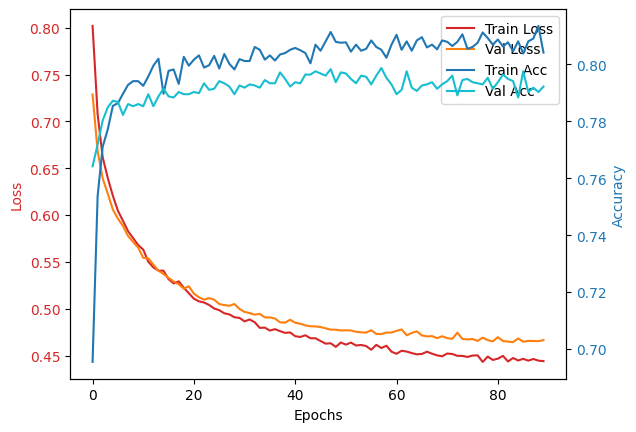


Additional Metrics:
F1 Score: 0.8157139704259545
ROC AUC Score: 0.8938126585736011

Interpreting the Graph:
- F1 Score: 2 * (precision * recall) / (precision + recall).  The F1 Score is the harmonic mean of precision and recall. Precision measures how many of the items identified as positive are actually positive, while recall measures how many of the actual positive items are identified correctly.
- ROC AUC Score: The Area Under the Receiver Operating Characteristic Curve (ROC AUC) is a measure of how well a model can distinguish between classes. An ROC AUC of 0.5 means the model is randomly guessing, while an ROC AUC of 1.0 means the model is perfectly distinguishing between positive and negative classes.
- A lower 'Loss' means the model is performing better.
- 'Train Loss' and 'Val Loss' should follow a similar trend. If 'Val Loss' starts increasing while 'Train Loss' continues decreasing, it's likely the model is overfitting.
- Higher 'Accuracy' is generally better, but be cautiou

In [27]:
# Define hyperparameters
hyperparameters = {
    "epochs": 100,  # Number of training epochs
    "batch_size": 32,  # Batch size for the training
    "dense_layer1_units": 128,  # Number of neurons in the first dense layer
    "dense_layer2_units": 64,  # Number of neurons in the second dense layer
    "dropout_rate1": 0.2,  # Dropout rate after the first dense layer
    "dropout_rate2": 0.3,  # Dropout rate after the second dense layer
    "optimizer": "adam",  # Optimization algorithm
    "learning_rate": 0.00017,  # Learning rate (if None, default for Adam is used)
    "l1_reg": 1e-4,  # L1 regularization strength
    "l2_reg": 1e-3,  # L2 regularization strength
    "early_stopping_monitor": "val_loss",  # Metric to monitor for early stopping
    "early_stopping_min_delta": 0,  # Minimum change in the monitored metric for early stopping
    "early_stopping_patience": 6,  # Number of epochs with no improvement to wait before stopping
    "early_stopping_verbose": 1,  # Verbosity mode
    "early_stopping_mode": "auto",  # Direction to be monitored ('auto', 'min', or 'max')
    "validation_split": 0.3,  # Fraction of the data to be used for validation
}

# Initialize EarlyStopping callback
early_stopping = EarlyStopping(
    monitor=hyperparameters["early_stopping_monitor"],
    min_delta=hyperparameters["early_stopping_min_delta"],
    patience=hyperparameters["early_stopping_patience"],
    verbose=hyperparameters["early_stopping_verbose"],
    mode=hyperparameters["early_stopping_mode"],
)

# List of features to include
selected_features = [
    "HomePlanet",
    "CryoSleep",
    "Age",
    "RoomService",
    "FoodCourt",
    "ShoppingMall",
    "Spa",
    "VRDeck",
    "Cabin_1",
    "Cabin_2",
    "Cabin_3",
]

# Separate features and target variable from training data
X_train_all = train_processed.drop("Transported", axis=1)
y_train = train_processed["Transported"]

# Filter the training data to include only the selected features
X_train = X_train_all[selected_features]

# Assuming test_processed also contains all potential features
X_test_all = test_processed
# Keep only the columns that are also present in the training set
X_test = X_test_all[X_train.columns]

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Build neural network model
predictor = Sequential(
    [
        Dense(
            hyperparameters["dense_layer1_units"],
            activation="relu",
            input_shape=(X_train_scaled.shape[1],),
            kernel_regularizer=regularizers.l1_l2(
                l1=hyperparameters["l1_reg"], l2=hyperparameters["l2_reg"]
            ),
        ),
        Dropout(hyperparameters["dropout_rate1"]),
        Dense(
            hyperparameters["dense_layer2_units"],
            activation="relu",
            kernel_regularizer=regularizers.l1_l2(
                l1=hyperparameters["l1_reg"], l2=hyperparameters["l2_reg"]
            ),
        ),
        Dropout(hyperparameters["dropout_rate2"]),
        Dense(1, activation="sigmoid"),  # Binary classification
    ]
)

# Compile the model
if hyperparameters["learning_rate"]:
    optimizer = Adam(learning_rate=hyperparameters["learning_rate"])
else:
    optimizer = hyperparameters["optimizer"]

predictor.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
history = predictor.fit(
    X_train_scaled,
    y_train,
    epochs=hyperparameters["epochs"],
    batch_size=hyperparameters["batch_size"],
    validation_split=hyperparameters["validation_split"],
    callbacks=[early_stopping],
)

# Make predictions on the test set (scaled)
y_test_pred = predictor.predict(X_test_scaled)
# Make predictions on the train set (scaled)
y_train_pred = predictor.predict(X_train_scaled)

predictor.summary()

# Evaluate model performance and plot metrics
plot_training_history_with_metrics(history, y_train, y_train_pred)

# Create the submission DataFrame
submission_df = create_submission_dataframe(y_test_pred, test["PassengerId"])

# Set Transported to boolean
submission_df["Transported"] = submission_df["Transported"].apply(
    lambda x: True if x == 1 else False
)
# To save the DataFrame as a CSV file
submission_df.to_csv("submission.csv", index=False)


In [28]:
# Assuming 'predictor' is your trained Keras model
weights_first_layer = predictor.layers[0].get_weights()[0]

# Summing absolute weights for each feature across all neurons in the first layer
feature_importance = np.sum(np.abs(weights_first_layer), axis=1)

# Creating a dictionary mapping feature names to their summed absolute weights
feature_importance_dict = dict(zip(X_train.columns, feature_importance))

# Sorting features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
print(sorted_features)


[('Spa', 9.264786), ('Cabin_2', 8.106905), ('VRDeck', 7.940337), ('CryoSleep', 7.442589), ('Cabin_3', 6.902055), ('Cabin_1', 6.676402), ('RoomService', 6.4687953), ('FoodCourt', 6.402826), ('ShoppingMall', 6.273531), ('HomePlanet', 6.183282), ('Age', 4.923515)]


## Create Submission

In [29]:
# Create the submission DataFrame
submission_df = create_submission_dataframe(y_test_pred, test["PassengerId"])

# Set Transported to boolean
submission_df["Transported"] = submission_df["Transported"].apply(
    lambda x: True if x == 1 else False
)
# To save the DataFrame as a CSV file
submission_df.to_csv("submission.csv", index=False)
